#Preprocessing data

Descripción:
- This notebook focus on explorate data that will be  use for test and training.
---
David Andrés Torres Betancour \\
System Engineering Student \\
Departamento de Ingeniería de Sistemas \\
Universidad de Antioquia \\
davida.torres@udea.edu.co

In [ ]:
import glob
from random import shuffle
import h5py
import numpy as np
import cv2
import math
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from google.colab import files
LE = LabelEncoder()
%matplotlib inline

In [192]:
def fetchDataFromKaggle():
  print("Upload kaggle.json file with credentials | IMPORTANT: Filename must be:kaggle.json\n")
  files.upload() #Upload file
  os.environ['KAGGLE_CONFIG_DIR'] = '/content' #Setup folder
  ! chmod 600 /content/kaggle.json  #Hide kaggle.json
  ! kaggle datasets download -d deividt/snake-breeds #Download dataset
  ! unzip \*.zip && rm *.zip #Unzip downloaded file and delete zip
  print("Loaded completed")

def reOrderForGrouping(dataF,group_size):

  dataF.sample(frac = 1)#Shuffle dataframe
  newDf = pd.DataFrame({'image_id' : [],'breed' : [],'breed_encode' : []})
  
  min_breedCount = dataF['breed'].value_counts()[-1]

  breeds = pd.unique(dataF['breed'])
  class_size = group_size //len(breeds)

  totalGroups = min_breedCount//class_size
 
  for i in range(totalGroups):

      for breed in   breeds :
          df_breed = dataF[dataF.breed==breed]
          df_breed = df_breed[class_size*i:class_size*(i+1)]
          newDf = newDf.append( df_breed )
  
  return newDf     

  types = ['.jpeg','.jpg','.png','.gif']

def normalize_and_write_data_into_h5_file(dest_filepath, dataF, n_px):
    

    data_shape = (len(dataF), n_px * n_px * 3)
    dataset_name = "input_data"
    

    with h5py.File(dest_filepath, 'a') as f:
        f.create_dataset(dataset_name, data_shape, np.float32)      
        for i,image_id in enumerate(dataF['image_id']):
            for t in types: 
              path  = BASE_PATH+"\\v2\dataset\data\\"+image_id+t
              try:
           
                img = cv2.imread(path)
             
                img = cv2.resize(img, (n_px, n_px), interpolation=cv2.INTER_CUBIC)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                #Normalize the image - convert the each pixel value between 0 and 1
                img = img / 255
                 #Reshape the image - roll it up into a column vector
                img = img.ravel()            
                #img[None] makes it a proper array instead of rank 1 array
                f[dataset_name][i, ...] = img[None]
                break
              except:
                continue

def write_labels_into_h5_file(dest_filepath, labels):
    
    dataset_name = "input_labels"
    
    with h5py.File(dest_filepath, 'a') as f:
        f.create_dataset(dataset_name, (len(labels),), np.int8)
        f[dataset_name][...] = labels

def convert_images_to_data_in_h5_file(dataF, dest_h5_file_path, n_px, batch_size = 1024):
    

    df2=dataF
    
    #Create Labels based upon the substring contained in the filename
    labels = (df2['breed_encode']).to_numpy()
    
    #Number of images
    m = len(df2) 
    n_complete_batches = math.ceil(m / batch_size)
    
    for i in range(n_complete_batches):
        print('Remaining  files',n_complete_batches-i)
       
        
        dest_file_path = dest_h5_file_path + str(i + 1) + ".h5"   
        
        start_pos = i * batch_size
        end_pos = min(start_pos + batch_size, m)
        df_filepaths_batch = df2.iloc[start_pos: end_pos]
        labels_batch = labels[start_pos: end_pos]
        normalize_and_write_data_into_h5_file(dest_file_path, df_filepaths_batch, n_px)
        write_labels_into_h5_file(dest_file_path, labels_batch)

    print("Files creation succeded")

In [ ]:
fetchDataFromKaggle()

Upload kaggle.json file with credentials | IMPORTANT: Filename must be:kaggle.json



Saving kaggle.json to kaggle.json
100% 3.53G/3.54G [01:04<00:00, 45.6MB/s]
100% 3.54G/3.54G [01:04<00:00, 58.6MB/s]
Archive:  snake-breeds.zip
replace data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data.csv                
  inflating: decode_breed.csv        
  inflating: group_1.h5              
  inflating: group_10.h5             
  inflating: group_2.h5              
  inflating: group_3.h5              
  inflating: group_4.h5              
  inflating: group_5.h5              
  inflating: group_6.h5              
  inflating: group_7.h5              
  inflating: group_8.h5              
  inflating: group_9.h5              
  inflating: originaldata.csv        
Loaded completed


In [109]:
#Read csv
df = pd.read_csv('originaldata.csv')
df.head(5)

binomial  ...                                         image_path
0  Pantherophis spiloides  ...  /Datasets/SnakeCLEF-2021/inaturalist/fbc816e95...
1   Masticophis taeniatus  ...  /Datasets/SnakeCLEF-2021/inaturalist/cbc7ad714...
2        Crotalus pyrrhus  ...  /Datasets/SnakeCLEF-2021/inaturalist/fc4db7295...
3        Haldea striatula  ...  /Datasets/SnakeCLEF-2021/inaturalist/2068c79c9...
4           Natrix natrix  ...  /Datasets/SnakeCLEF-2021/inaturalist/3e376aaf4...

[5 rows x 10 columns]

In [110]:
#Dropping propierties
df = df.drop(columns=['source','class_id','image_path','country','genus','family','continent','subset'])

#Renaming columns
df.columns=['breed','image_id']
df.head(5)


breed                          image_id
0  Pantherophis spiloides  fbc816e9552643a2bce4f655b2f3c4e1
1   Masticophis taeniatus  cbc7ad7141a642f2b92ef7fe05c9d608
2        Crotalus pyrrhus  fc4db72953ae4c978ac50acb33adce0c
3        Haldea striatula  2068c79c956d43dc8a45106e0c808aed
4           Natrix natrix  3e376aaf4f8d42e991c0c8ddc5972f95

In [111]:
print("Total breeds:",len ( pd.unique(df['breed'])))

Total breeds: 772


- Select top 10 breeds with most images

In [112]:
df['breed'].value_counts()[:10]

Thamnophis sirtalis            22163
Storeria dekayi                17535
Pantherophis obsoletus         13012
Crotalus atrox                 12344
Nerodia sipedon                12211
Pituophis catenifer            11487
Pantherophis alleghaniensis     8846
Agkistrodon contortrix          8085
Diadophis punctatus             7689
Nerodia erythrogaster           7435
Name: breed, dtype: int64

In [113]:
options = [ 'Thamnophis sirtalis',            
            'Storeria dekayi',                
            'Pantherophis obsoletus',         
            'Crotalus atrox',                 
            'Nerodia sipedon',                
            'Pituophis catenifer',            
            'Pantherophis alleghaniensis',    
            'Agkistrodon contortrix',         
            'Diadophis punctatus',            
            'Nerodia erythrogaster'] 

df = df[df['breed'].isin(options)] 

print(pd.unique(df['breed']))

print("Total breeds:",len ( pd.unique(df['breed'])))

['Thamnophis sirtalis' 'Pituophis catenifer' 'Storeria dekayi'
 'Nerodia erythrogaster' 'Diadophis punctatus' 'Crotalus atrox'
 'Pantherophis alleghaniensis' 'Nerodia sipedon' 'Agkistrodon contortrix'
 'Pantherophis obsoletus']
Total breeds: 10


- Adding column with breed encode value

In [114]:
df['breed_encode'] = LE.fit_transform(df['breed'])
df.head(5)

breed                          image_id  breed_encode
14    Thamnophis sirtalis  2925c677825448a7935fad227c1fa9b2             9
17    Pituophis catenifer  1b849238b16941b282c2d608a8c4c687             7
21        Storeria dekayi  dab7fe49d8204bce887305fd5fa887c0             8
22  Nerodia erythrogaster  7c4bd815bf0b4454b6db043fccd54fd1             3
24    Diadophis punctatus  7060dc6cb41e4fcc8415a9007ac3bca6             2

In [190]:
df['breed'].value_counts()

Thamnophis sirtalis            22163
Storeria dekayi                17535
Pantherophis obsoletus         13012
Crotalus atrox                 12344
Nerodia sipedon                12211
Pituophis catenifer            11487
Pantherophis alleghaniensis     8846
Agkistrodon contortrix          8085
Diadophis punctatus             7689
Nerodia erythrogaster           7435
Name: breed, dtype: int64

- Order dataframe for groups

In [191]:
df = reOrderForGrouping( df,group_size=2000)
df['breed'].value_counts()

Pantherophis alleghaniensis    7400
Pituophis catenifer            7400
Nerodia erythrogaster          7400
Diadophis punctatus            7400
Crotalus atrox                 7400
Agkistrodon contortrix         7400
Nerodia sipedon                7400
Pantherophis obsoletus         7400
Thamnophis sirtalis            7400
Storeria dekayi                7400
Name: breed, dtype: int64

In [ ]:
dest_filepath = 'group_'
n_px = 224
n_channels = 3
convert_images_to_data_in_h5_file(df, dest_filepath, n_px, batch_size= 2000)


c:\Users\datcx\Documents\udea\pdi\proyect2\v6\batchs\group_
Creating file 1
Actual position:  2000
Creating file 2
Actual position:  4000
Creating file 3
Actual position:  6000
Creating file 4
Actual position:  8000
Creating file 5
Actual position:  10000
Creating file 6
Actual position:  12000
Creating file 7
Actual position:  14000
Creating file 8
Actual position:  16000
Creating file 9
Actual position:  18000
Creating file 10
Actual position:  20000
Creating file 11
Actual position:  22000
Creating file 12
Actual position:  24000
Creating file 13
Actual position:  26000
Creating file 14
Actual position:  28000
Creating file 15
Actual position:  30000
Creating file 16
Actual position:  32000
Creating file 17
Actual position:  34000
Creating file 18
Actual position:  36000
Creating file 19
Actual position:  38000
Creating file 20
Actual position:  40000
Creating file 21
Actual position:  42000
Creating file 22
Actual position:  44000
Creating file 23
Actual position:  46000
Creating f

In [ ]:
destination_filepath = BASE_PATH+'\oficial\\batchs\snakes_'+'1.h5'
with h5py.File(destination_filepath, "r") as f:
    
    print(list(f.keys()))
    
    x = f["input_data"][:]
    y = f["input_labels"][:]

    print('x shape =', x.shape, '| y shape =', y.shape)

['input_data', 'input_labels']
x shape = (2048, 150528) | y shape = (2048,)


y = 30


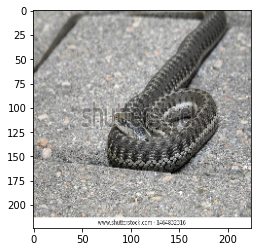

In [ ]:
import random
index = random.randint(0,1024)
image = x[index]
#print(image)
#print(image.shape)
image = (x[index]).reshape(224, 224, 3)
plt.imshow(image)
print('y =', y[index])